In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Lambda
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import pescador
from scipy.stats import zscore
import gzip
import os
import fnmatch

import theano
print('theano version: {:s}'.format(theano.__version__))

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)


theano version: 0.9.0beta1


## Define data generators

In [2]:
def _bag_activation(activation, min_active_frames, act_threshold=0.5):
    '''
    Given activation curve (time series) with values in the range [0, 1], 
    the minimum number of required active frames and athreshold for considering 
    a frame active (default 0.5), return whether the bag defined by this activation
    curve is active (returns 1) or not (returns 0)
    '''
    condition = activation >= act_threshold
    # The following computes the length of every consecutive sequence
    # of True's in condition:
    active_lengths = np.diff(np.where(np.concatenate(
        ([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2]
    # Need at least min_active_frames to consider bag as positive
    if len(active_lengths) > 0:
        bag_label = 1 * (active_lengths.max() >= min_active_frames)
    else:
        bag_label = 0
        
    return bag_label


def _generate_bag(trackid, cqt, act, frame, n_bag_frames, min_active_frames, act_threshold=0.5):
    
    # Carve out TF patch, standardize (optional) and reshape
#     patch = cqt[:, frame:frame + n_bag_frames]
#     if zscore_std:
#         patch = zscore(patch, axis=None)
#     patch = patch.reshape(-1, patch.shape[0], patch.shape[1], 1)

    # Compute bag label
    patch_act = act[frame:frame+n_bag_frames]
    bag_label = _bag_activation(patch_act, min_active_frames, act_threshold=act_threshold)

    # Compute bag ID
    bagid = '{:s}_{:d}'.format(trackid, frame)    

    return dict(
#         X=patch,
        X=(cqt[:, frame:frame+n_bag_frames]).reshape(-1, cqt.shape[0], n_bag_frames, 1),
        Y=np.asarray([bag_label], dtype=np.int32),
        ID=np.asarray([bagid]))

In [3]:
def mil_bag_generator(cqtfile, actfile, n_bag_frames, min_active_frames, n_hop_frames, 
                      act_threshold=0.5, zscore_std=False, shuffle=True):
    '''
    Generate a MIL bag with corresponding label. 
    The function yields a dictionary with three elements: 
    X = features, Y = label, Z = bag ID (trackid + first frame index).

    Parameters
    ----------
    cqtfile : str
        Path to .npy.gz file containing the log-CQT matrix
    actfile : str
        Path to .npy.gz file containing the activation vector
    n_bag_frames : int
        Number of frames to include in a bag
    min_active_frames: int
        Minimum number of consecutive active frames to consider bag positive
    n_hop_frames : int
        Number of frames to jump between consecutive bags
    zscore : bool
        Whether or not to standardize the bag features (zscore)
    shuffle : bool
        Whether to shuffle the ordering of the bags (for sgd) or not (for
        validation and test)

    Returns
    -------
    bag : dictionary with X = features, Y = label, Z = bag ID
    '''
    # Load cqt file and ativation file
    cqt = np.load(gzip.open(cqtfile, 'rb'))
    act = np.load(gzip.open(actfile, 'rb'))
    
    # Get bag ID (from filename)
    trackid = '_'.join(os.path.basename(cqtfile).split('_')[:2])

    order = np.arange(0, cqt.shape[1]-n_bag_frames, n_hop_frames) # librosa puts time in dim 1
    if shuffle:
        np.random.shuffle(order)

    for frame in order:
        yield _generate_bag(trackid, cqt, act, frame, n_bag_frames, min_active_frames, act_threshold=act_threshold)

In [4]:
def infinite_mil_bag_generator(cqtfile, actfile, n_bag_frames, min_active_frames,
                               n_hop_frames, act_threshold=0.5, zscore_std=False, shuffle=True):
    '''
    Generate infinitely many MIL bags with corresponding label. 
    The function yields a dictionary with three elements: 
    X = features, Y = label, Z = bag ID (trackid + first frame index).

    Parameters
    ----------
    cqtfile : str
        Path to .npy.gz file containing the log-CQT matrix
    actfile : str
        Path to .npy.gz file containing the activation vector
    n_bag_frames : int
        Number of frames to include in a bag
    min_active_frames: int
        Minimum number of consecutive active frames to consider bag positive
    n_hop_frames : int
        Number of frames to jump between consecutive bags
    zscore : bool
        Whether or not to standardize the bag features (zscore)
    shuffle : bool
        Whether to shuffle the ordering of the bags (for sgd) or not (for
        validation and test)

    Returns
    -------
    bag : dictionary with X = features, Y = label, Z = bag ID
    '''
    # DEBUG
#     print(cqtfile)
#     print(actfile)
    assert os.path.isfile(cqtfile)
    assert os.path.isfile(actfile)
    
    # Load cqt file and ativation file
    cqt = np.load(gzip.open(cqtfile, 'rb'))
    act = np.load(gzip.open(actfile, 'rb'))
    
    # Get bag ID (from filename)
    trackid = '_'.join(os.path.basename(cqtfile).split('_')[:2])

    frame = -1
    while True:
        if shuffle:
            frame = np.random.randint(0, cqt.shape[1] - n_bag_frames)
        else:
            frame = np.mod(frame + n_hop_frames, cqt.shape[1] - n_bag_frames)

        yield _generate_bag(trackid, cqt, act, frame, n_bag_frames, min_active_frames, act_threshold=act_threshold)

In [5]:
def batch_mux(streams, batch_size, n_samples=None, n_active=1000,
              with_replacement=False):
    '''
    Multiplex streams into batches of size n_batch

    Parameters
    ----------
    streams : list of pescador.Streamer
        The list of streams to multiplex
    batch_size : int > 0
        Number of samples to in each batch (batch size)
    n_samples : int or None
        Number of individual samples to generate (limit). If None, generate
        infinite number of samples (unless with_replacement is False in which
        case generate until all streams are exhausted)
    n_active : int > 0
        Number of streams that can be active simultaneously
    with_replacement : bool
        If true sample form streams indefinitely. If False streams are sampled
        until exhausted.

    Returns
    -------
    batch_streamer : pescador.Streamer
        Batch multiplexer
    '''

    stream_mux = pescador.Streamer(
        pescador.mux, streams, n_samples, n_active,
        with_replacement=with_replacement)

    batch_streamer = pescador.Streamer(
        pescador.buffer_streamer, stream_mux, batch_size)

    return batch_streamer

In [6]:
def vad_minibatch_generator(root_folder, track_list,
                            augmentations=['original'],
                            feature='cqt44100_1024_8_36', 
                            activation='vocal_activation44100_1024',
                            n_bag_frames=44,
                            min_active_frames=2,
                            act_threshold=0.5,
                            n_hop_frames=22,
                            zscore_std=False,
                            shuffle=True,
                            batch_size=100, 
                            n_samples=None,
                            n_active=1000,
                            with_replacement=False):
    """

    Parameters
    ----------
    root_folder
    track_list
    augmentations
    feature
    activation
    n_bag_frames
    min_activate_frames
    act_threshold
    n_hop_frames
    zscore_std
    shuffle
    batch_size
    n_samples
    n_active
    with_replacement

    Returns
    -------

    """
    # DEBUG
#     print("Collecting feature files...")
    
    # Collect all feature and activation files
    cqt_files = []
    act_files = []
    for track in track_list:
        for aug in augmentations:
            cqt_folder = os.path.join(root_folder, aug, 'features', feature)
            cqtfile = os.path.join(cqt_folder, '{:s}_cqt.npy.gz'.format(track))
            act_folder = os.path.join(os.path.dirname(cqt_folder), activation)
            actfile = os.path.join(act_folder, '{:s}_vocalactivation.npy.gz')
            
            cqt_files.append(cqtfile)
            act_files.append(actfile)
                
    # DEBUG
#     print("Found {:d} files".format(len(cqt_files)))
#     print("Creating streams...")

    # Turn all files into streams
    streams = []
    for cqtfile in cqt_files:
        # get matching activation file
        actfolder = os.path.join(os.path.dirname(os.path.dirname(cqtfile)), activation)
        actfile = os.path.join(actfolder, os.path.basename(cqtfile).replace('_cqt.npy.gz', 
                                                                            '_vocalactivation.npy.gz'))
        assert os.path.isfile(actfile)
        
        if with_replacement:
            streams.append(pescador.Streamer(infinite_mil_bag_generator, 
                                             cqtfile, actfile, n_bag_frames, min_active_frames, 
                                             n_hop_frames, act_threshold, zscore_std, shuffle))
        else:
            streams.append(pescador.Streamer(mil_bag_generator, cqtfile, actfile,
                                             n_bag_frames, min_active_frames, n_hop_frames, 
                                             act_threshold, zscore_std, shuffle))
        
    # DEBUG
#     print("Done")

    # Mux the streams into minimbatches
    batch_streamer = batch_mux(streams, batch_size, n_samples=n_samples,
                               n_active=n_active, 
                               with_replacement=with_replacement)

    return batch_streamer

In [7]:
def keras_vad_minibatch_generator(root_folder, track_list,
                                  augmentations=['original'],
                                  feature='cqt44100_1024_8_36', 
                                  activation='vocal_activation44100_1024',
                                  n_bag_frames=44,
                                  min_active_frames=10,
                                  act_threshold=0.5,
                                  n_hop_frames=22,
                                  zscore_std=False,
                                  shuffle=True,
                                  batch_size=32, 
                                  n_samples=None,
                                  n_active=1000,
                                  with_replacement=False):
    """

    Parameters
    ----------
    root_folder
    track_list
    augmentations
    feature
    activation
    n_bag_frames
    min_activate_frames
    n_hop_frames
    zscore_std
    shuffle
    batch_size
    n_samples
    n_active
    with_replacement

    Returns
    -------

    """
    keras_generator = vad_minibatch_generator(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    for batch in keras_generator.generate():
        yield (batch['X'], batch['Y'])

## Construct generators

In [8]:
split = np.load('../data/dataSplits_7_1_2.pkl')

In [54]:
# TRAIN GENERATOR
root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
track_list = split[2][0]
augmentations = ['original']
feature = 'cqt44100_1024_8_36'
activation = 'vocal_activation44100_1024'
n_bag_frames = 44
min_active_frames = 10
act_threshold = 0.5
n_hop_frames = 22
zscore_std= False
shuffle = True
batch_size = 32
n_samples = None
n_active = 1000
with_replacement = True

train_generator = keras_vad_minibatch_generator(
    root_folder, track_list, augmentations, feature, activation,
    n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
    shuffle, batch_size, n_samples, n_active, with_replacement)

In [55]:
# VALIDATE GENERATOR
root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
track_list = split[2][1]
augmentations = ['original']
feature = 'cqt44100_1024_8_36'
activation = 'vocal_activation44100_1024'
n_bag_frames = 44
min_active_frames = 10
act_threshold = 0.5
n_hop_frames = 22
zscore_std= False
shuffle = True
batch_size = 1024
n_samples = None
n_active = 1000
with_replacement = False

validate_generator = keras_vad_minibatch_generator(
    root_folder, track_list, augmentations, feature, activation,
    n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
    shuffle, batch_size, n_samples, n_active, with_replacement)

In [56]:
# # DEBUG: get one batch
# for n, batch in enumerate(train_generator):
#     X_train = batch[0]
#     Y_train = batch[1]
#     break

In [57]:
# print(X_train.shape, Y_train.shape)

In [58]:
# Y_train

## Define softmax pooling layer

In [9]:
# LAMBDA VERSION

def _keras_smp(x):
    m = K.max(x, axis=-1, keepdims=True)
    sm = K.exp(x - m)
    w = sm / K.sum(sm, axis=-1, keepdims=True)
    return K.sum(x * w, axis=-1, keepdims=True)
    
def _keras_smp_shape(input_shape):
    shape = list(input_shape)
    shape[-1] = 1
    return tuple(shape)

LSoftMaxPool = Lambda(_keras_smp, output_shape=_keras_smp_shape)

In [10]:
# KERAS LAYER VERSION
class SoftMaxPool(Layer):
    '''Apply soft-max pooling '''
    def __init__(self, axis=-1, **kwargs):
        
        super(SoftMaxPool, self).__init__(**kwargs)
        
        self.axis = axis
        
    def get_output_shape_for(self, input_shape):
        
        shape = list(input_shape)
        shape[self.axis] = 1
        return tuple(shape)
    
    def call(self, x, mask=None):
        
        m = K.max(x, axis=self.axis, keepdims=True)
        sm = K.exp(x - m)
        w = sm / K.sum(sm, axis=self.axis, keepdims=True)
        return K.sum(x * w, axis=self.axis, keepdims=True)
    
    def get_config(self):
        config = {'axis': self.axis}
        base_config = super(SoftMaxPool, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Squeeze layer

In [11]:
def _keras_squeeze(x, axis=1):
    return K.squeeze(x, axis=axis)

def _keras_squeeze_shape(input_shape):
    shape = np.array(input_shape)
    shape = shape[shape!=1]
    return tuple(shape)

SqueezeLayer = Lambda(_keras_squeeze, output_shape=_keras_squeeze_shape, arguments={'axis': 1})
SqueezeLastLayer = Lambda(_keras_squeeze, output_shape=_keras_squeeze_shape, arguments={'axis': -1})

In [12]:
# KERAS LAYER VERSION
class KSqueezeLayer(Layer):
    
    def __init__(self, axis=-1, **kwargs):
        
        super(KSqueezeLayer, self).__init__(**kwargs)
        self.axis = axis
        
    def get_output_shape_for(self, input_shape):
        
        shape = np.array(input_shape)
        shape = shape[shape!=1]
        return tuple(shape)
    
    def call(self, x, mask=None):
        
        return K.squeeze(x, axis=self.axis)
    
    def get_config(self):
        config = {'axis': self.axis}
        base_config = super(KSqueezeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Define model

In [62]:
# input TF dimensions
tf_rows, tf_cols = 288, 44
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
# pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
fullheight_kernel_size = (tf_rows, 1)

In [63]:
if K.image_dim_ordering() == 'th':
    input_shape = (1, tf_rows, tf_cols)
else:
    input_shape = (tf_rows, tf_cols, 1)
print(input_shape)

(288, 44, 1)


In [64]:
inputs = Input(shape=input_shape)
b1 = BatchNormalization()(inputs)
y1 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='y1')(b1)
b2 = BatchNormalization()(y1)
y2 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='y2')(b2)
b3 = BatchNormalization()(y2)
y3 = Convolution2D(nb_filters, fullheight_kernel_size[0], fullheight_kernel_size[1], 
                  border_mode='valid', activation='relu', name='y3')(b3)
b4 = BatchNormalization()(y3)
y4 = SqueezeLayer(b4)
y5 = Convolution1D(1, 1, border_mode='valid', activation='sigmoid', name='y5')(y4)
y6 = SqueezeLastLayer(y5)
predictions = LSoftMaxPool(y6)

model = Model(input=inputs, output=predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 288, 44, 1)    0                                            
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 288, 44, 1)    4           input_5[0][0]                    
____________________________________________________________________________________________________
y1 (Convolution2D)               (None, 288, 44, 32)   320         batchnormalization_17[0][0]      
____________________________________________________________________________________________________
batchnormalization_18 (BatchNorm (None, 288, 44, 32)   128         y1[0][0]                         
___________________________________________________________________________________________

In [66]:
# TEST TOY EXAMPLE TO SEE MODEL DOESN'T EXPLODE
# history = model.fit(X_train, Y_train, batch_size=10, nb_epoch=10, verbose=1)

In [67]:
# TRY TO USED VAD GENERATOR (TRAIN ONLY)
# history = model.fit_generator(train_generator, 1000, 100, verbose=1)

In [68]:
# GET ONE BACTCH FOR VALIDATION (always use same batch)
for n, batch in enumerate(validate_generator):
    X_val = batch[0]
    Y_val = batch[1]
    break
    
validation_batch = (X_val, Y_val)
print(X_val.shape, Y_val.shape)

(1024, 288, 44, 1) (1024,)


In [69]:
print('0: {:d}'.format(np.sum(Y_val==0)))
print('1: {:d}'.format(np.sum(Y_val==1)))

0: 403
1: 621


In [70]:
# VAD GENERATOR (TRAIN + VALIDATE)
samples_per_epoch = 1024
nb_epochs = 10
nb_val_samples = 1024

history = model.fit_generator(train_generator, samples_per_epoch, nb_epochs, verbose=1, 
                              validation_data=validation_batch, nb_val_samples=1024)

Epoch 1/10
1024/1024 [==============================] - 324s - loss: 0.5613 - acc: 0.7266 - val_loss: 0.6208 - val_acc: 0.7705

In [71]:
# TEST

# TEST GENERATOR
root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
track_list = split[2][2]
augmentations = ['original']
feature = 'cqt44100_1024_8_36'
activation = 'vocal_activation44100_1024'
n_bag_frames = 44
min_active_frames = 10
act_threshold = 0.5
n_hop_frames = 22
zscore_std= False
shuffle = False
batch_size = 1024
n_samples = None
n_active = 1000
with_replacement = False

test_generator = keras_vad_minibatch_generator(
    root_folder, track_list, augmentations, feature, activation,
    n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
    shuffle, batch_size, n_samples, n_active, with_replacement)

X_test = []
Y_test = []

for batch in test_generator:
    X_test.extend(batch[0])
    Y_test.extend(batch[1])
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

print(X_test.shape)
print(Y_test.shape)

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

(6252, 288, 44, 1)
(6252,)
Test score: 0.690798539499
Test accuracy: 0.545745361484


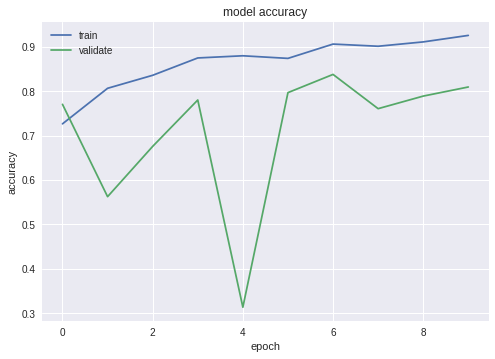

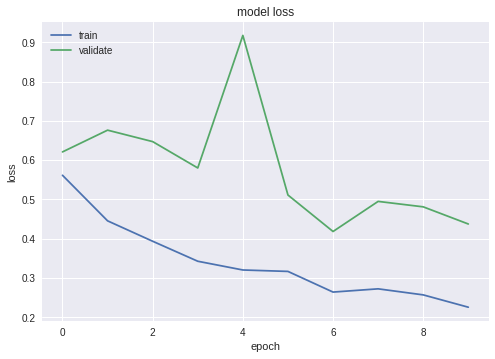

In [74]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [75]:
# TODO
# 1. add back 2nd conv layer: DONE
# 2. code up proper train/validate/test splits: DONE
# 3. Move to infinite generator: DONE
# 4. use keras callback to checkpoint best model:
# 5. dropout?
# 6. min_activate_frames?

## Try the new SMP layer

In [39]:
###### MODEL PARAMETERS ######
# input TF dimensions
tf_rows, tf_cols = 288, 44
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
# pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
fullheight_kernel_size = (tf_rows, 1)

if K.image_dim_ordering() == 'th':
    input_shape = (1, tf_rows, tf_cols)
else:
    input_shape = (tf_rows, tf_cols, 1)
print(input_shape)
######

##### MODEL ARCHITECTURE #####
inputs = Input(shape=input_shape)
b1 = BatchNormalization()(inputs)
y1 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='y1')(b1)
b2 = BatchNormalization()(y1)
y2 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='y2')(b2)
b3 = BatchNormalization()(y2)
y3 = Convolution2D(nb_filters, fullheight_kernel_size[0], fullheight_kernel_size[1], 
                  border_mode='valid', activation='relu', name='y3')(b3)
b4 = BatchNormalization()(y3)
y4 = SqueezeLayer(b4)
y5 = Convolution1D(1, 1, border_mode='valid', activation='sigmoid', name='y5')(y4)
y6 = SqueezeLastLayer(y5)
predictions = SoftMaxPool()(y6)

model = Model(input=inputs, output=predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(288, 44, 1)


In [13]:
###### DATA GENERATORS #####
# Utility to avoid repetition in the notebook
def get_data_generators():
    
    # TRAIN GENERATOR
    root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
    track_list = split[2][0]
    augmentations = ['original']
    feature = 'cqt44100_1024_8_36'
    activation = 'vocal_activation44100_1024'
    n_bag_frames = 44
    min_active_frames = 10
    act_threshold = 0.5
    n_hop_frames = 22
    zscore_std= False
    shuffle = True
    batch_size = 32
    n_samples = None
    n_active = 1000
    with_replacement = True

    train_generator = keras_vad_minibatch_generator(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    # VALIDATE GENERATOR
    track_list = split[2][1]
    shuffle = False
    batch_size = 1024
    n_samples = None
    n_active = 1000
    with_replacement = False

    validate_generator = keras_vad_minibatch_generator(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    # TEST GENERATOR
    track_list = split[2][2]
    augmentations = ['original']

    test_generator = keras_vad_minibatch_generator(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, min_active_frames, act_threshold, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    return train_generator, validate_generator, test_generator

In [41]:
# Get data generators
train_generator, validate_generator, test_generator = get_data_generators()

# Get full validation & test data
X_val = []
Y_val = []

for batch in validate_generator:
    X_val.extend(batch[0])
    Y_val.extend(batch[1])
    
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

print('Validation set:')
print(X_val.shape)
print(Y_val.shape)
print('0: {:d}'.format(np.sum(Y_val==0)))
print('1: {:d}'.format(np.sum(Y_val==1)))
print(' ')

X_test = []
Y_test = []

for batch in test_generator:
    X_test.extend(batch[0])
    Y_test.extend(batch[1])
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

print('Test set:')
print(X_test.shape)
print(Y_test.shape)
print('0: {:d}'.format(np.sum(Y_test==0)))
print('1: {:d}'.format(np.sum(Y_test==1)))
print(' ')

Validation set:
(2379, 288, 44, 1)
(2379,)
0: 825
1: 1554
 
Test set:
(6188, 288, 44, 1)
(6188,)
0: 3012
1: 3176
 


In [42]:
# ADD CHECKPOINTING
checkpointer = ModelCheckpoint(filepath="/scratch/js7561/datasets/MedleyDB_output/models/notebook/weights.hdf5", 
                               verbose=0, save_best_only=True)

samples_per_epoch = 1024
nb_epochs = 20

history = model.fit_generator(train_generator, samples_per_epoch, nb_epochs, verbose=1, 
                              validation_data=(X_val, Y_val), callbacks=[checkpointer])

Epoch 1/20
1024/1024 [==============================] - 362s - loss: 0.6974 - acc: 0.5889 - val_loss: 0.6279 - val_acc: 0.5918

In [43]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.650617087165
Test accuracy: 0.70168067225


In [52]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 288, 44, 1)    0                                            
____________________________________________________________________________________________________
batchnormalization_9 (BatchNorma (None, 288, 44, 1)    4           input_3[0][0]                    
____________________________________________________________________________________________________
y1 (Convolution2D)               (None, 288, 44, 32)   320         batchnormalization_9[0][0]       
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 288, 44, 32)   128         y1[0][0]                         
___________________________________________________________________________________________

# FRAME-LEVEL OUTPUT

In [14]:
###### MODEL PARAMETERS ######
# input TF dimensions
tf_rows, tf_cols = 288, 44
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
# pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
fullheight_kernel_size = (tf_rows, 1)

if K.image_dim_ordering() == 'th':
    input_shape = (1, tf_rows, tf_cols)
else:
    input_shape = (tf_rows, tf_cols, 1)
print(input_shape)
######

##### MODEL ARCHITECTURE #####
inputs = Input(shape=input_shape, name='input')
b1 = BatchNormalization(name='b1')(inputs)
y1 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='c1')(b1)
b2 = BatchNormalization(name='b2')(y1)
y2 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='c2')(b2)
b3 = BatchNormalization(name='b3')(y2)
y3 = Convolution2D(nb_filters, fullheight_kernel_size[0], fullheight_kernel_size[1], 
                  border_mode='valid', activation='relu', name='c3')(b3)
b4 = BatchNormalization(name='b4')(y3)
y4 = KSqueezeLayer(axis=1, name='s4')(b4)
y5 = Convolution1D(1, 1, border_mode='valid', activation='sigmoid', name='c4')(y4)
y6 = KSqueezeLayer(axis=-1, name='s5')(y5)
predictions = SoftMaxPool(name='smp')(y6)

model = Model(input=inputs, output=predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss={'smp':'binary_crossentropy', 's5': 0}, optimizer='adam', metrics=['accuracy'])

(288, 44, 1)


In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 288, 44, 1)    0                                            
____________________________________________________________________________________________________
b1 (BatchNormalization)          (None, 288, 44, 1)    4           input[0][0]                      
____________________________________________________________________________________________________
c1 (Convolution2D)               (None, 288, 44, 32)   320         b1[0][0]                         
____________________________________________________________________________________________________
b2 (BatchNormalization)          (None, 288, 44, 32)   128         c1[0][0]                         
___________________________________________________________________________________________

In [16]:
# Get data generators
train_generator, validate_generator, test_generator = get_data_generators()

# Get full validation & test data
X_val = []
Y_val = []

for batch in validate_generator:
    X_val.extend(batch[0])
    Y_val.extend(batch[1])
    
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

print('Validation set:')
print(X_val.shape)
print(Y_val.shape)
print('0: {:d}'.format(np.sum(Y_val==0)))
print('1: {:d}'.format(np.sum(Y_val==1)))
print(' ')

X_test = []
Y_test = []

for batch in test_generator:
    X_test.extend(batch[0])
    Y_test.extend(batch[1])
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

print('Test set:')
print(X_test.shape)
print(Y_test.shape)
print('0: {:d}'.format(np.sum(Y_test==0)))
print('1: {:d}'.format(np.sum(Y_test==1)))
print(' ')

Validation set:
(2434, 288, 44, 1)
(2434,)
0: 862
1: 1572
 
Test set:
(6333, 288, 44, 1)
(6333,)
0: 3141
1: 3192
 


In [17]:
# TRAIN MODEL WITH NEW LAYER NAMES
checkpointer = ModelCheckpoint(filepath="/scratch/js7561/datasets/MedleyDB_output/models/notebook/weights.hdf5", 
                               verbose=0, save_best_only=True)
samples_per_epoch = 1024
nb_epochs = 50
history = model.fit_generator(train_generator, samples_per_epoch, nb_epochs, verbose=1, 
                              validation_data=(X_val, Y_val), callbacks=[checkpointer])

Epoch 1/50
1024/1024 [==============================] - 363s - loss: 0.6043 - acc: 0.7021 - val_loss: 0.5874 - val_acc: 0.8213

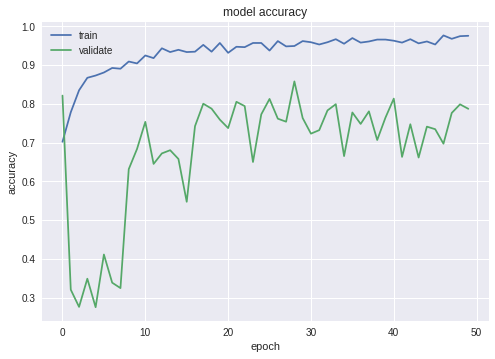

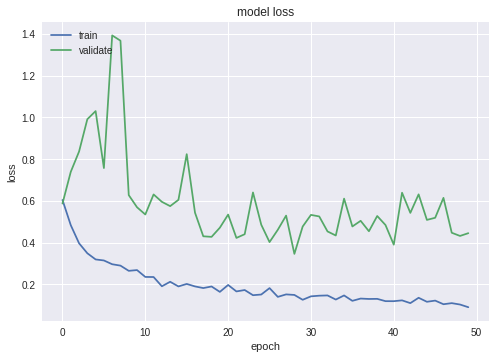

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [19]:
# FRAME PREDICTOR MODEL

##### MODEL ARCHITECTURE #####
finputs = Input(shape=input_shape, name='input')
fb1 = BatchNormalization(name='b1')(finputs)
fy1 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='c1')(fb1)
fb2 = BatchNormalization(name='b2')(fy1)
fy2 = Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same', activation='relu', name='c2')(fb2)
fb3 = BatchNormalization(name='b3')(fy2)
fy3 = Convolution2D(nb_filters, fullheight_kernel_size[0], fullheight_kernel_size[1], 
                  border_mode='valid', activation='relu', name='c3')(fb3)
fb4 = BatchNormalization(name='b4')(fy3)
fy4 = KSqueezeLayer(axis=1, name='s4')(fb4)
fy5 = Convolution1D(1, 1, border_mode='valid', activation='sigmoid', name='c4')(fy4)
fy6 = KSqueezeLayer(axis=-1, name='s5')(fy5)

fmodel = Model(input=finputs, output=fy6)
# fmodel.compile(loss='binary_crossentropy',
#                optimizer='adam',
#                metrics=['accuracy'])

In [20]:
weightfile = "/scratch/js7561/datasets/MedleyDB_output/models/notebook/weights.hdf5"
fmodel.load_weights(weightfile, by_name=True)

## Create frame-level data generators

In [21]:
def _generate_bag_frames(trackid, cqt, act, frame, n_bag_frames, act_threshold=0.5):

    # Compute bag label
    patch_act = act[frame:frame+n_bag_frames]

    # Compute bag ID
    bagid = '{:s}_{:d}'.format(trackid, frame)

    return dict(
        X=(cqt[:, frame:frame+n_bag_frames]).reshape(-1, cqt.shape[0], n_bag_frames, 1),
        Y= (1 * (patch_act >= act_threshold)).reshape(1, -1),
        ACT=patch_act.reshape(1, -1),
        ID=np.asarray([bagid]))

In [22]:
def mil_bag_generator_frames(cqtfile, actfile, n_bag_frames, n_hop_frames, 
                             act_threshold=0.5, zscore_std=False, shuffle=True):
    # Load cqt file and ativation file
    cqt = np.load(gzip.open(cqtfile, 'rb'))
    act = np.load(gzip.open(actfile, 'rb'))
    
    # Get bag ID (from filename)
    trackid = '_'.join(os.path.basename(cqtfile).split('_')[:2])

    order = np.arange(0, cqt.shape[1]-n_bag_frames, n_hop_frames) # librosa puts time in dim 1
    if shuffle:
        np.random.shuffle(order)

    for frame in order:
        yield _generate_bag_frames(trackid, cqt, act, frame, n_bag_frames, act_threshold=act_threshold)

In [23]:
def vad_minibatch_generator_frames(
    root_folder, track_list, augmentations=['original'], feature='cqt44100_1024_8_36', 
    activation='vocal_activation44100_1024', n_bag_frames=44,
    act_threshold=0.5, n_hop_frames=22, zscore_std=False, shuffle=True, batch_size=100, 
    n_samples=None, n_active=1000, with_replacement=False):
    
    # Collect all feature and activation files
    cqt_files = []
    for track in track_list:
        for aug in augmentations:
            cqt_folder = os.path.join(root_folder, aug, 'features', feature)
            cqtfile = os.path.join(cqt_folder, '{:s}_cqt.npy.gz'.format(track))
            cqt_files.append(cqtfile)
                
    # Turn all files into streams
    streams = []
    for cqtfile in cqt_files:
        # get matching activation file
        actfolder = os.path.join(os.path.dirname(os.path.dirname(cqtfile)), activation)
        actfile = os.path.join(actfolder, os.path.basename(cqtfile).replace('_cqt.npy.gz', 
                                                                            '_vocalactivation.npy.gz'))
        assert os.path.isfile(actfile)
        
        streams.append(pescador.Streamer(mil_bag_generator_frames, cqtfile, actfile,
                                         n_bag_frames, n_hop_frames, 
                                         act_threshold, zscore_std, shuffle))
        
    # Mux the streams into minimbatches
    batch_streamer = batch_mux(streams, batch_size, n_samples=n_samples,
                               n_active=n_active, 
                               with_replacement=with_replacement)

    return batch_streamer

In [24]:
###### DATA GENERATORS #####
# Utility to avoid repetition in the notebook
def get_test_generator_frames():
    
    # TEST GENERATOR
    root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
    track_list = split[2][2]
    augmentations = ['original']
    feature = 'cqt44100_1024_8_36'
    activation = 'vocal_activation44100_1024'
    n_bag_frames = 44
    act_threshold = 0.5
    n_hop_frames = 22
    zscore_std= False
    shuffle = False
    batch_size = 1024
    n_samples = None
    n_active = 1000
    with_replacement = False

    test_generator = vad_minibatch_generator_frames(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, act_threshold, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    return test_generator

In [25]:
test_generator = get_test_generator_frames()

In [26]:
X_test = []
Y_test = []
ACT_test = []
ID_test = []

for batch in test_generator.generate():
    X_test.extend(batch['X'])
    Y_test.extend(batch['Y'])
    ACT_test.extend(batch['ACT'])
    ID_test.extend(batch['ID'])
    
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
ACT_test = np.asarray(ACT_test)
ID_test = np.asarray(ID_test)

print('Test set:')
print(X_test.shape)
print(Y_test.shape)
print(ACT_test.shape)
print(ID_test.shape)

Test set:
(6196, 288, 44, 1)
(6196, 44)
(6196, 44)
(6196,)


In [27]:
pred = fmodel.predict(X_test)

Mozart_BesterJungling_1100


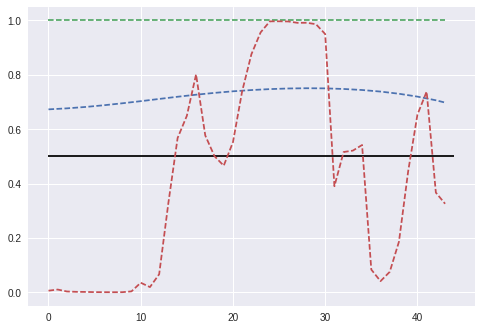

In [43]:
ind = np.random.randint(pred.shape[0])

fig = plt.figure()
plt.plot(ACT_test[ind], '--')
plt.plot(Y_test[ind], '--')
plt.plot(pred[ind], '--')
plt.hlines(0.5, 0, 44)
print(ID_test[ind])